In [1]:
!pip install wordcloud
!pip install gensim
!pip install spacy
!pip install xgboost

In [2]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.5 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Análise de Currículos



In [3]:
### Processamento de Dados ###
import numpy as np  # linear algebra
import pandas as pd

### Visualização de Dados ###
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

### Processamento de Texto ###
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
nlp = spacy.load("en_core_web_sm")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import re

### Machine Learning ###
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
# from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from xgboost import XGBClassifier


[nltk_data] Downloading package punkt to /home/gabiiwa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabiiwa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gabiiwa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Currículos do projeto ["Resume Dataset"](https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset/data)


In [4]:
df_resume = pd.read_csv('../dados/Resume/Resume.csv')
df_resume.rename(columns={"Resume_str":"Resume"},inplace=True,errors='ignore')
display(df_resume.head())
display(f"Quantas entradas:{df_resume.shape[0]}")

,ID,Resume,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


'Quantas entradas:2484'

In [5]:
# drop colunas que não estão sendo usadas
df_resume.drop(columns = ['ID', 'Resume_html'], inplace = True,errors='ignore')

In [6]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

## Currículos do projeto ["Updated Resume Dataset"](https://www.kaggle.com/datasets/jillanisofttech/updated-resume-dataset/data)


In [7]:
df_update = pd.read_csv("../dados/update_resume/UpdatedResumeDataSet.csv")

display(df_update.head())
display(f"Quantas entradas:{df_update.shape[0]}")

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


'Quantas entradas:962'

In [8]:
df_update.Category.unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [9]:
df_update["Category"] = df_update.Category.str.upper()
df_update

,Category,Resume
0,DATA SCIENCE,Skills * Programming Languages: Python (pandas...
1,DATA SCIENCE,Education Details \r\nMay 2013 to May 2017 B.E...
2,DATA SCIENCE,"Areas of Interest Deep Learning, Control Syste..."
3,DATA SCIENCE,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,DATA SCIENCE,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,TESTING,Computer Skills: â¢ Proficient in MS office (...
958,TESTING,â Willingness to accept the challenges. â ...
959,TESTING,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,TESTING,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


## Definindo Cenários para os testes
Neste etapa serão feitos os testes em dois datasets: um com o df_resume que foram os dados usados no teste do artigo e outro dataframe com os dados do artigo e os novos dados(update)

In [10]:
df_curr = pd.concat([df_resume,df_update],ignore_index=True)
df_curr

,Resume,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR
...,...,...
3441,Computer Skills: â¢ Proficient in MS office (...,TESTING
3442,â Willingness to accept the challenges. â ...,TESTING
3443,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",TESTING
3444,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,TESTING


In [11]:
df_curr.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION',
       'DATA SCIENCE', 'WEB DESIGNING', 'MECHANICAL ENGINEER',
       'HEALTH AND FITNESS', 'CIVIL ENGINEER', 'JAVA DEVELOPER',
       'BUSINESS ANALYST', 'SAP DEVELOPER', 'AUTOMATION TESTING',
       'ELECTRICAL ENGINEERING', 'OPERATIONS MANAGER', 'PYTHON DEVELOPER',
       'DEVOPS ENGINEER', 'NETWORK SECURITY ENGINEER', 'PMO', 'DATABASE',
       'HADOOP', 'ETL DEVELOPER', 'DOTNET DEVELOPER', 'BLOCKCHAIN',
       'TESTING'], dtype=object)

In [12]:
display(df_curr.describe())
print(f'Valores nulos? {True if sum(df_curr.isna().any())>0 else False}')
# print(f'Valores duplicados? {True if df_curr.duplicated().sum()>0 else False}')

,Resume,Category
count,3446,3446
unique,2648,45
top,"Technical Skills Web Technologies: Angular JS,...",SALES
freq,18,156


Valores nulos? False


In [13]:
df_curr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446 entries, 0 to 3445
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Resume    3446 non-null   object
 1   Category  3446 non-null   object
dtypes: object(2)
memory usage: 54.0+ KB


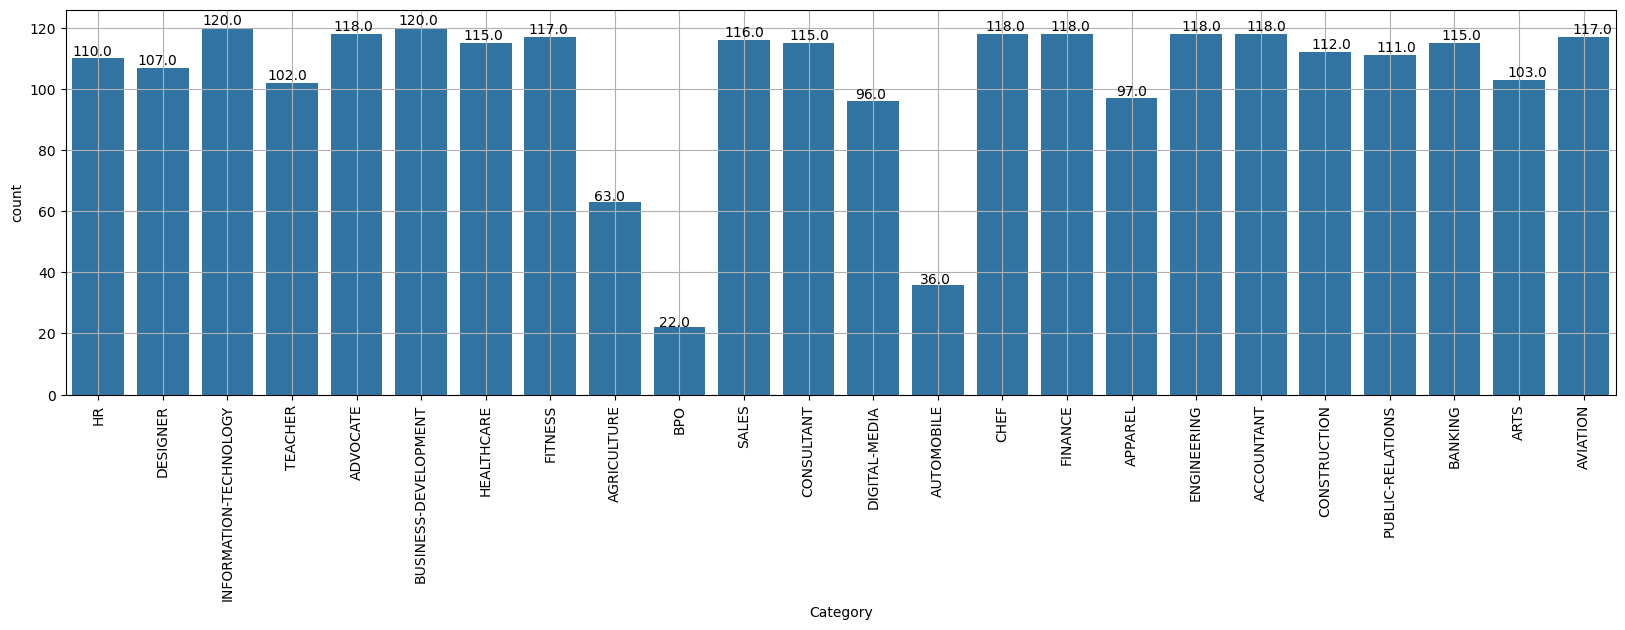

In [14]:
#### Dataframe com as catogerias do artigo ######
# Plotando histogramas de quantidade de curriculos por categoria
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
ax=sns.countplot(x="Category", data=df_resume)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.grid()

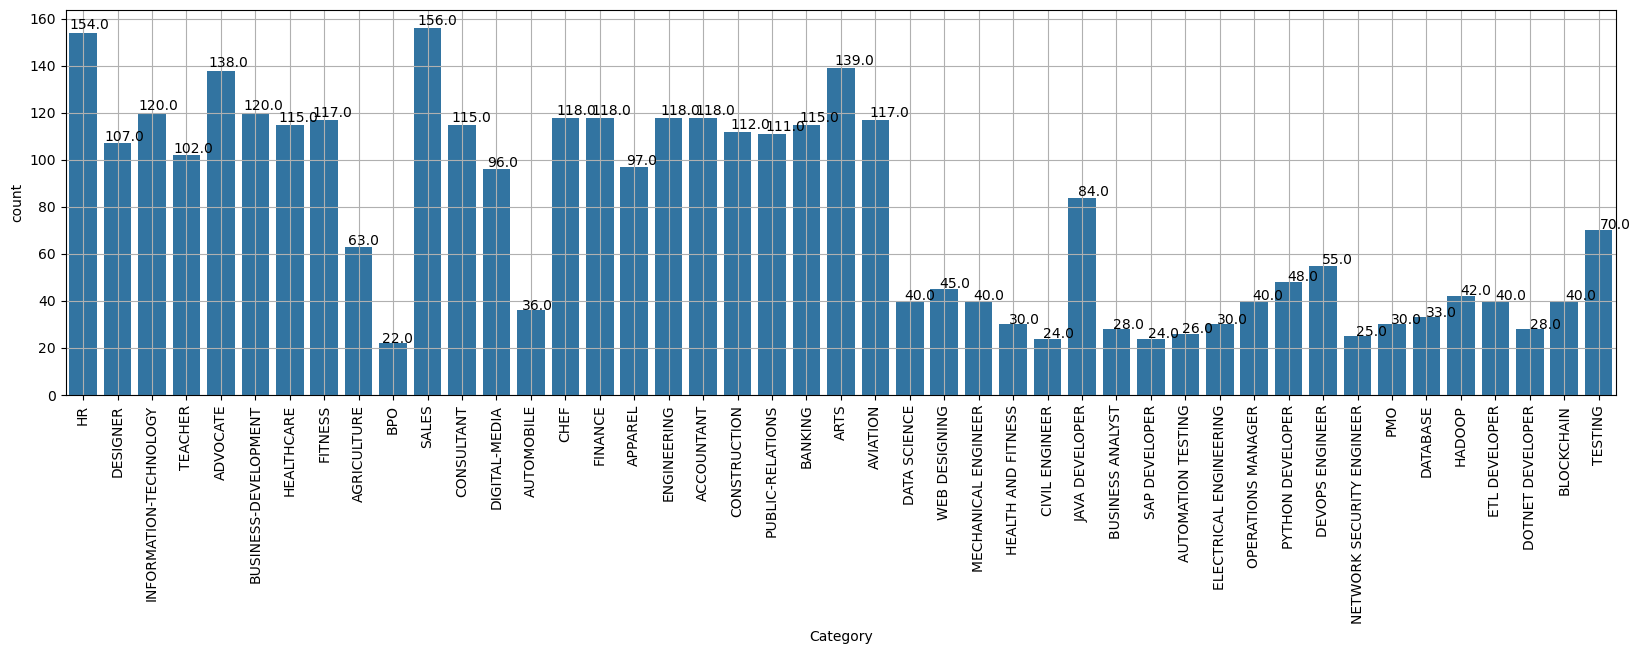

In [15]:
#### Dataframe com todas as catorias ######
# Plotando histogramas de quantidade de curriculos por categoria
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
ax=sns.countplot(x="Category", data=df_curr)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.grid()

## Pré-processamento
* Limpar o texto removendo caracteres especiais, pontuações e espaços extras.
* Converter o texto para maiúscula para padronização.
* Remover stop words (palavras comuns que não contribuem para a análise).
* Tokenizar usando o nltk


In [16]:
# Stemming e Lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_words(tokens):
    return [stemmer.stem(word) for word in tokens]

def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]


In [17]:
def preprocess(txt):
    # convertendo o texto para maiuscula
    txt = txt.lower()
    # removendo caracteres especiais, espaços extras, pontuações e números
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = re.sub('http\S+\s*', ' ', txt)  # removendo URLs
    txt = re.sub('RT|cc', ' ', txt)  # removendo informações desnecessárias
    txt = re.sub('#\S+', '', txt)  # removendo hashtags
    txt = re.sub('@\S+', '  ', txt)  # removendo menções
    txt = re.sub('\s+', ' ', txt)  # removendo espaçoes extras
    # tokenize
    txt = nltk.tokenize.word_tokenize(txt)
    # removendo stop words
    txt = [w for w in txt if not w in nltk.corpus.stopwords.words('english')]

    txt = stem_words(txt)
    txt = lemmatize_words(txt)
    return ' '.join(txt)

In [18]:
# limpando a coluna de curriculos de valores não conhecidos
df_resume["resume_cleaned"] = df_resume["Resume"].apply(lambda x:preprocess(x))
df_curr["resume_cleaned"] = df_curr["Resume"].apply(lambda x:preprocess(x))

In [ ]:
display(df_curr)
display(df_resume)

,Resume,Category,resume_cleaned
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administr market associ hr administr summar...
1,"HR SPECIALIST, US HR OPERATIONS ...",HR,hr specialist u hr oper summari versatil mediu...
2,HR DIRECTOR Summary Over 2...,HR,hr director summari year experi recruit plu ye...
3,HR SPECIALIST Summary Dedica...,HR,hr specialist summari dedic driven dynam year ...
4,HR MANAGER Skill Highlights ...,HR,hr manag skill highlight hr skill hr depart st...
...,...,...,...
3441,Computer Skills: â¢ Proficient in MS office (...,TESTING,comput skill profici m offic word basic excel ...
3442,â Willingness to accept the challenges. â ...,TESTING,willing ept challeng posit think good learner ...
3443,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",TESTING,person skill quick learner eager learn new thi...
3444,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,TESTING,comput skill softwar knowledg m power point m ...


,Resume,Category,resume_cleaned
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administr market associ hr administr summar...
1,"HR SPECIALIST, US HR OPERATIONS ...",HR,hr specialist u hr oper summari versatil mediu...
2,HR DIRECTOR Summary Over 2...,HR,hr director summari year experi recruit plu ye...
3,HR SPECIALIST Summary Dedica...,HR,hr specialist summari dedic driven dynam year ...
4,HR MANAGER Skill Highlights ...,HR,hr manag skill highlight hr skill hr depart st...
...,...,...,...
2479,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,AVIATION,rank sgt e non commiss offic charg brigad mail...
2480,"GOVERNMENT RELATIONS, COMMUNICATIONS ...",AVIATION,govern relat commun organiz develop director p...
2481,GEEK SQUAD AGENT Professional...,AVIATION,geek squad agent profession profil support spe...
2482,PROGRAM DIRECTOR / OFFICE MANAGER ...,AVIATION,program director offic manag summari highli pe...


In [ ]:
df_curr.to_csv("resume_todos_tokenizado.csv",sep=';')
df_resume.to_csv("resume_artigo_tokenizado.csv",sep=';')

## Reconhecimento de Entidades Nomeadas (NER)

In [ ]:
# Função para extração de entidades
def extract_entities(text):
    doc = nlp(text)
    entities = [(entity.text, entity.label_) for entity in doc.ents]
    return entities

In [ ]:
df_resume['entities'] = df_resume['resume_cleaned'].apply(extract_entities)
df_resume[['resume_cleaned', 'entities']].head()

,resume_cleaned,entities
0,hr administr market associ hr administr summar...,"[(associ, PERSON), (administr summari dedic cu..."
1,hr specialist u hr oper summari versatil mediu...,"[(experi, NORP), (manag commun, PERSON), (poli..."
2,hr director summari year experi recruit plu ye...,"[(summari year, PERSON), (plu year, DATE), (hr..."
3,hr specialist summari dedic driven dynam year ...,"[(summari dedic, PERSON), (servic, NORP), (mot..."
4,hr manag skill highlight hr skill hr depart st...,"[(hr manag skill highlight, PERSON), (three, C..."


In [ ]:
df_curr['entities'] = df_curr['resume_cleaned'].apply(extract_entities)
df_curr[['resume_cleaned', 'entities']].head()

,resume_cleaned,entities
0,hr administr market associ hr administr summar...,"[(associ, PERSON), (administr summari dedic cu..."
1,hr specialist u hr oper summari versatil mediu...,"[(experi, NORP), (manag commun, PERSON), (poli..."
2,hr director summari year experi recruit plu ye...,"[(summari year, PERSON), (plu year, DATE), (hr..."
3,hr specialist summari dedic driven dynam year ...,"[(summari dedic, PERSON), (servic, NORP), (mot..."
4,hr manag skill highlight hr skill hr depart st...,"[(hr manag skill highlight, PERSON), (three, C..."


In [ ]:
df_resume.to_csv("artigo_ner.csv",";")
df_curr.to_csv("todos_ner.csv",";")

## TF-IDF


In [ ]:
#### Curriculos usados no Artigo ####
# Função para extrair apenas o texto das entidades 
def extract_entity_text(entities):
    return ' '.join([entity[0] for entity in entities])

# Extrair textos das entidades
df_resume['entities_text'] = df_resume['entities'].apply(extract_entity_text)

# Inicializar o vetor TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # max_features pode ser ajustado conforme necessário

# Ajustar e transformar os dados
X = vectorizer.fit_transform(df_resume['entities_text'])

# Converter para DataFrame
tfidf_df_resume = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Exibir as primeiras linhas
tfidf_df_resume.head()

,abc,abil,abus,academ,achiev,acrobat,act,activ,ada,adapt,...,winter,work,workflow,workplac,xerox,year,ymca,york,zero,zumba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049485,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.044461,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074202,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035159,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.094769,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.190486,0.0,...,0.0,0.0,0.0,0.0,0.0,0.030387,0.0,0.0,0.0,0.0


In [ ]:
tfidf_df_resume

,abc,abil,abus,academ,achiev,acrobat,act,activ,ada,adapt,...,winter,work,workflow,workplac,xerox,year,ymca,york,zero,zumba
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.049485,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.044461,0.0,0.0,0.000000,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.074202,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.035159,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.094769,0.0,0.0,0.000000,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.190486,0.0,...,0.0,0.0,0.0,0.0,0.0,0.030387,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2479,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.054771,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.421749,0.0
2480,0.0,0.100712,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.050596,0.0,0.0,0.000000,0.0
2481,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.078132,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2482,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.126694,0.0,0.0,0.000000,0.0


In [ ]:
#### Curriculos Update ####
# Extrair textos das entidades
df_curr['entities_text'] = df_curr['entities'].apply(extract_entity_text)

# Inicializar o vetor TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # max_features pode ser ajustado conforme necessário

# Ajustar e transformar os dados
X = vectorizer.fit_transform(df_curr['entities_text'])

# Converter para DataFrame
tfidf_df_curr = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Exibir as primeiras linhas
tfidf_df_curr.head()

,abc,abil,abus,academ,achiev,act,activ,ada,administr,admiss,...,wipro,work,workplac,xen,xerox,xml,year,ymca,york,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.050237,0.000000,0.202138,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.043858,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.073364,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.035940,0.000000,0.048203,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.094129,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.195601,0.047021,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.030607,0.0,0.0,0.0


## Classificação e Modelagem


In [232]:
class Model_Classification:
    def __init__(self, df, variables, target):
        self.variable = variables
        self.target = target
        self.df = df[variables + [target]]
        self.df_train, self.df_validation = train_test_split(self.df, test_size=0.2, random_state=42)
        self.best_params = None
        self.best_f1 = float('inf')
        self.final_model = None
        self.grid = None
        self.class_origin = df[target].unique()  # Captura as classes originais antes da transformação
        self.confusion_matrices = []  # Lista para armazenar as matrizes de confusão de cada fold

    def evaluation_metrics(self, y_true, y_pred):
        """Calculate and return model evaluation metrics"""
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        rec = recall_score(y_true, y_pred, average='macro')
        prec = precision_score(y_true, y_pred, average='macro')
        return {'accuracy': acc, 'f1_score': f1, 'recall': rec, 'precision': prec}

    def building_best_model(self, model, param_dist, cv=5):
        """Train and find the best model with KFold cross-validation"""
        X = self.df_train[self.variable]
        y = self.df_train[self.target].values.ravel()

        # Set up KFold cross-validation
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        
        best_f1 = float('-inf')
        best_params = None
        best_model = None

        for params in param_dist:
            model.set_params(**params)
            fold_f1_scores = []

            self.confusion_matrices = []  # Resetar as matrizes de confusão para cada conjunto de parâmetros

            for train_index, val_index in kf.split(X):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y[train_index], y[val_index]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                fold_f1 = f1_score(y_val, y_pred, average='macro')
                fold_f1_scores.append(fold_f1)

                # Adicionar a matriz de confusão para este fold
                cm = confusion_matrix(y_val, y_pred)
                self.confusion_matrices.append(cm)

            avg_f1 = np.mean(fold_f1_scores)

            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_params = params
                best_model = model

        self.best_params = best_params
        self.final_model = best_model
        self.best_f1 = best_f1
        
        # Train the final model on the entire training set
        self.final_model.fit(X, y)

    def plot_confusion_matrix(self):
        """Plot the average confusion matrix of the validation set predictions."""
        if not self.confusion_matrices:
            print("No confusion matrices found. Please run building_best_model first.")
            return

        # Calcular a matriz de confusão média
        avg_cm = np.mean(self.confusion_matrices, axis=0)

        # Get class labels
        class_labels = {num: value for num, value in enumerate(self.class_origin)}

        # Plotting the average confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(avg_cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
        plt.title('Average Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

    def predict(self, new_data):
        """Make predictions with the final model on new data."""
        if self.final_model is None:
            print("Final model is not trained. Please run train_final_model first.")
            return
        return self.final_model.predict(new_data[self.variable])

#### Cenário com dados do Artigo Base

In [233]:
# Definindo as variáveis independentes (X) e a variável dependente (y)
variables = tfidf_df_resume.columns.tolist()  # As colunas TF-IDF como variáveis
df_tfidf_resume = tfidf_df_resume.copy()
print(variables)

target = 'Category' 

# Adicionando a coluna de rótulo ao DataFrame tfidf_df
df_tfidf_resume[target] = df_resume[target].replace({value:num for num,value in enumerate(df_resume[target].unique(),start=0)})
print(df_tfidf_resume[target])
# Inicializar a classe de classificação
model_classification = Model_Classification(df_tfidf_resume, variables, target, df_resume[target].unique())

['abc', 'abil', 'abus', 'academ', 'achiev', 'acrobat', 'act', 'activ', 'ada', 'adapt', 'administr', 'admiss', 'adob', 'advanc', 'advertis', 'advisori', 'advoc', 'afghanistan', 'africa', 'african', 'age', 'agenc', 'agil', 'air', 'aircraft', 'airfield', 'airlin', 'aix', 'al', 'allen', 'allianc', 'alloc', 'america', 'american', 'analys', 'analyt', 'analyz', 'anatomi', 'android', 'angel', 'annual', 'antonio', 'appli', 'applic', 'appoint', 'approach', 'appropri', 'approv', 'april', 'aptitud', 'arab', 'area', 'aris', 'arizona', 'arkansa', 'armi', 'aros', 'arrang', 'arriv', 'art', 'articl', 'articul', 'asia', 'asian', 'assembl', 'assign', 'assist', 'associ', 'assur', 'atlanta', 'attend', 'attitud', 'audit', 'aug', 'august', 'austin', 'autom', 'auxiliari', 'avail', 'averag', 'aviat', 'awar', 'award', 'bachelor', 'background', 'backup', 'balanc', 'bank', 'banker', 'base', 'baselin', 'basi', 'bay', 'bba', 'beach', 'beauti', 'behavior', 'believ', 'benefit', 'bilingu', 'bill', 'billion', 'bin', 'b

##### SVM

fold_f1: 0.03939101283073097
fold_f1: 0.07603437853437851
fold_f1: 0.04313699383243075
fold_f1: 0.02312817439936084
fold_f1: 0.044065484052204874
avg_f1:0.04515120872982119
fold_f1: 0.39881315063303946
fold_f1: 0.33871793413431206
fold_f1: 0.3798234354947743
fold_f1: 0.4005656281610999
fold_f1: 0.33014005289240994
avg_f1:0.3696120402631271
fold_f1: 0.3551059157794034
fold_f1: 0.33172925115336266
fold_f1: 0.33504264642025455
fold_f1: 0.3426523501929288
fold_f1: 0.3079917656273082
avg_f1:0.33450438583465153
fold_f1: 0.0036630036630036634
fold_f1: 0.00255338904363974
fold_f1: 0.0036630036630036634
fold_f1: 0.0025605214152700185
fold_f1: 0.002785515320334262
avg_f1:0.003045086621050269
fold_f1: 0.4083475454928527
fold_f1: 0.3539435617870365
fold_f1: 0.36145230304472936
fold_f1: 0.38753912178169525
fold_f1: 0.34524750090638695
avg_f1:0.37130600660254015
Best params: {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}


/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM Metrics: {'accuracy': 0.42359249329758714, 'f1_score': 0.3839147783207011, 'recall': 0.3840121935756458, 'precision': 0.41557178320697713}
class_label: {0: 'HR', 1: 'DESIGNER', 2: 'INFORMATION-TECHNOLOGY', 3: 'TEACHER', 4: 'ADVOCATE', 5: 'BUSINESS-DEVELOPMENT', 6: 'HEALTHCARE', 7: 'FITNESS', 8: 'AGRICULTURE', 9: 'BPO', 10: 'SALES', 11: 'CONSULTANT', 12: 'DIGITAL-MEDIA', 13: 'AUTOMOBILE', 14: 'CHEF', 15: 'FINANCE', 16: 'APPAREL', 17: 'ENGINEERING', 18: 'ACCOUNTANT', 19: 'CONSTRUCTION', 20: 'PUBLIC-RELATIONS', 21: 'BANKING', 22: 'ARTS', 23: 'AVIATION'}


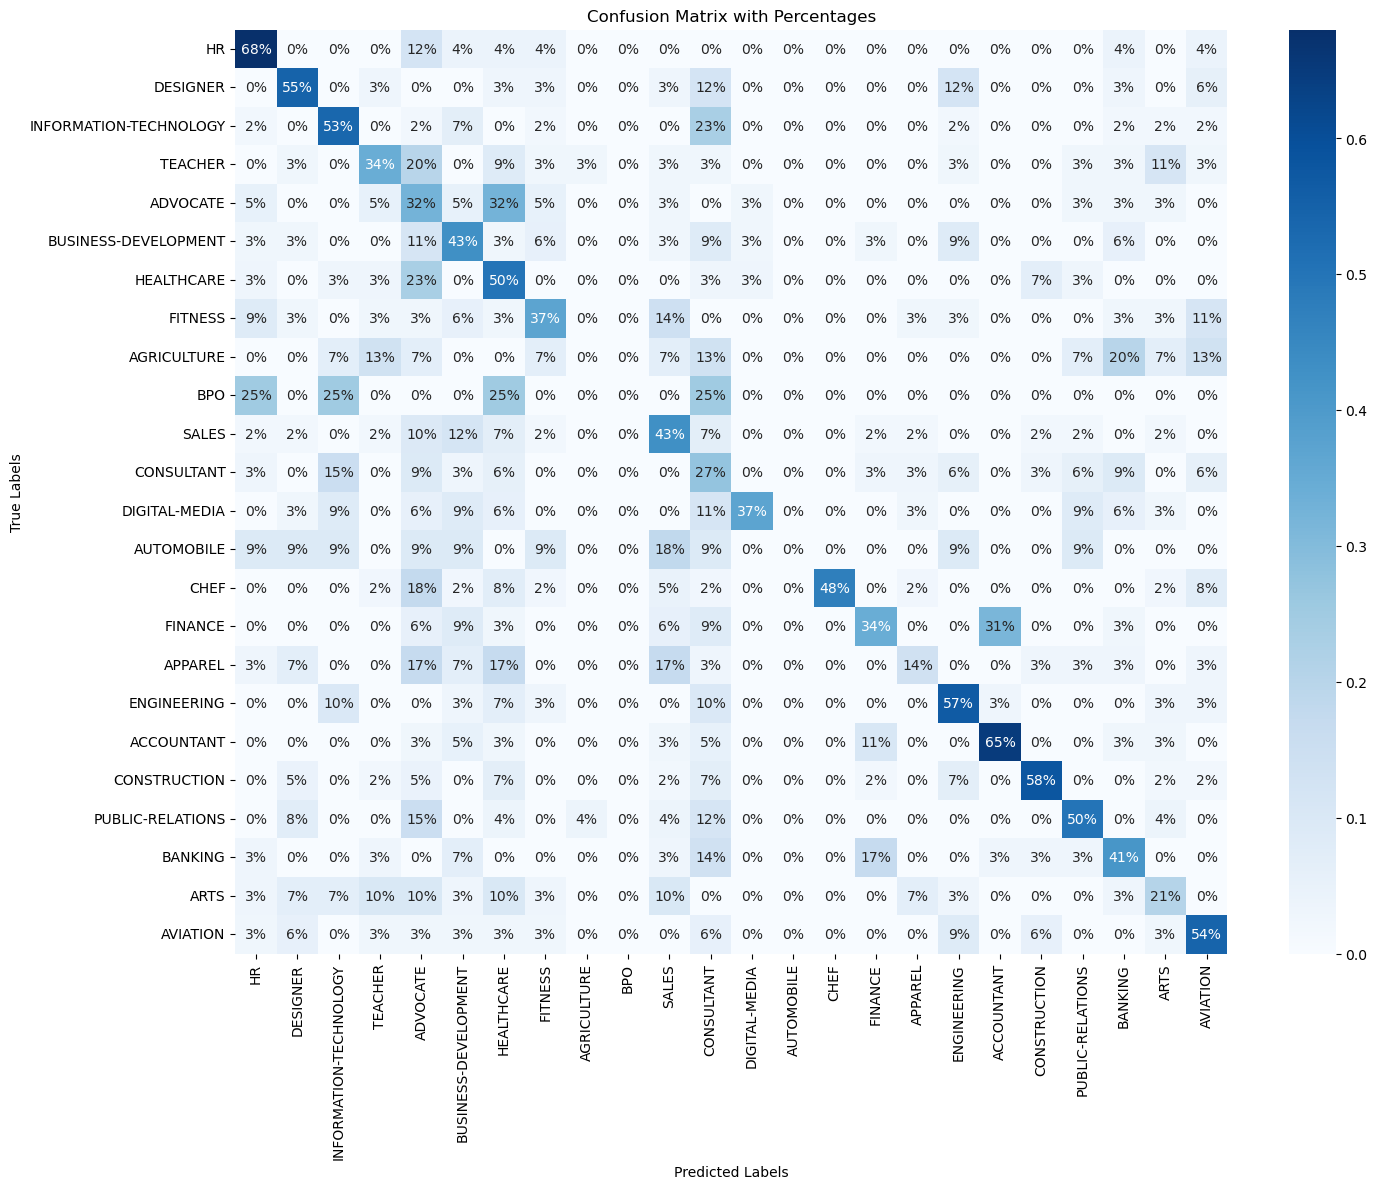

In [234]:
# Definindo os parâmetros para o SVM
svm_param_dist = [
    {'C': 0.1, 'kernel': 'linear'},
    {'C': 1, 'kernel': 'linear'},
    {'C': 10, 'kernel': 'linear'},
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale'},
    {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'},
    # {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'}
]

# Treinando e encontrando o melhor modelo SVM
svm_model = SVC()
model_classification.building_best_model(svm_model, svm_param_dist, cv=5)

# Avaliando o modelo SVM
svm_predictions = model_classification.predict(model_classification.df_validation)
svm_metrics = model_classification.evaluation_metrics(model_classification.df_validation[model_classification.target], svm_predictions)
print(f'SVM Metrics: {svm_metrics}')

# Plotando a matriz de confusão
model_classification.plot_confusion_matrix()

##### XGBoost

In [238]:
# Inicializar a classe de classificação
model_classification_xgb = Model_Classification(df_tfidf_resume, variables, target,df_resume[target].unique())

Target dentro da lista de variaveis: False


In [241]:
from itertools import product
# Definindo os parâmetros para o XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Convertendo para lista de dicionários
keys, values = zip(*xgb_param_grid.items())
xgb_param_dist = [dict(zip(keys, v)) for v in product(*values)]

fold_f1: 0.3557965086921364
fold_f1: 0.3761207924396987
fold_f1: 0.34558498651606495
avg_f1:0.3591674292159667
fold_f1: 0.3494019120526124
fold_f1: 0.36286455043568705
fold_f1: 0.3514436206587548
avg_f1:0.35457002771568474
fold_f1: 0.3526453607992492
fold_f1: 0.35772781162754513
fold_f1: 0.33878450516643555
avg_f1:0.34971922586440995
fold_f1: 0.3412086486247845
fold_f1: 0.3552312451449821
fold_f1: 0.339346499780855
avg_f1:0.3452621311835406
fold_f1: 0.35613156378258776
fold_f1: 0.3703001008200002
fold_f1: 0.34565797249488045
avg_f1:0.3573632123658228
fold_f1: 0.3496324237254258
fold_f1: 0.36294148008000165
fold_f1: 0.354049257955589
avg_f1:0.3555410539203388
fold_f1: 0.34171872623084004
fold_f1: 0.37320168787338037
fold_f1: 0.3447079928477817
avg_f1:0.3532094689840007
fold_f1: 0.3264079299718806
fold_f1: 0.33679404264460616
fold_f1: 0.3338045108982565
avg_f1:0.33233549450491445
fold_f1: 0.3564319881047689
fold_f1: 0.363607932589947
fold_f1: 0.34030952820197685
avg_f1:0.3534498162988975

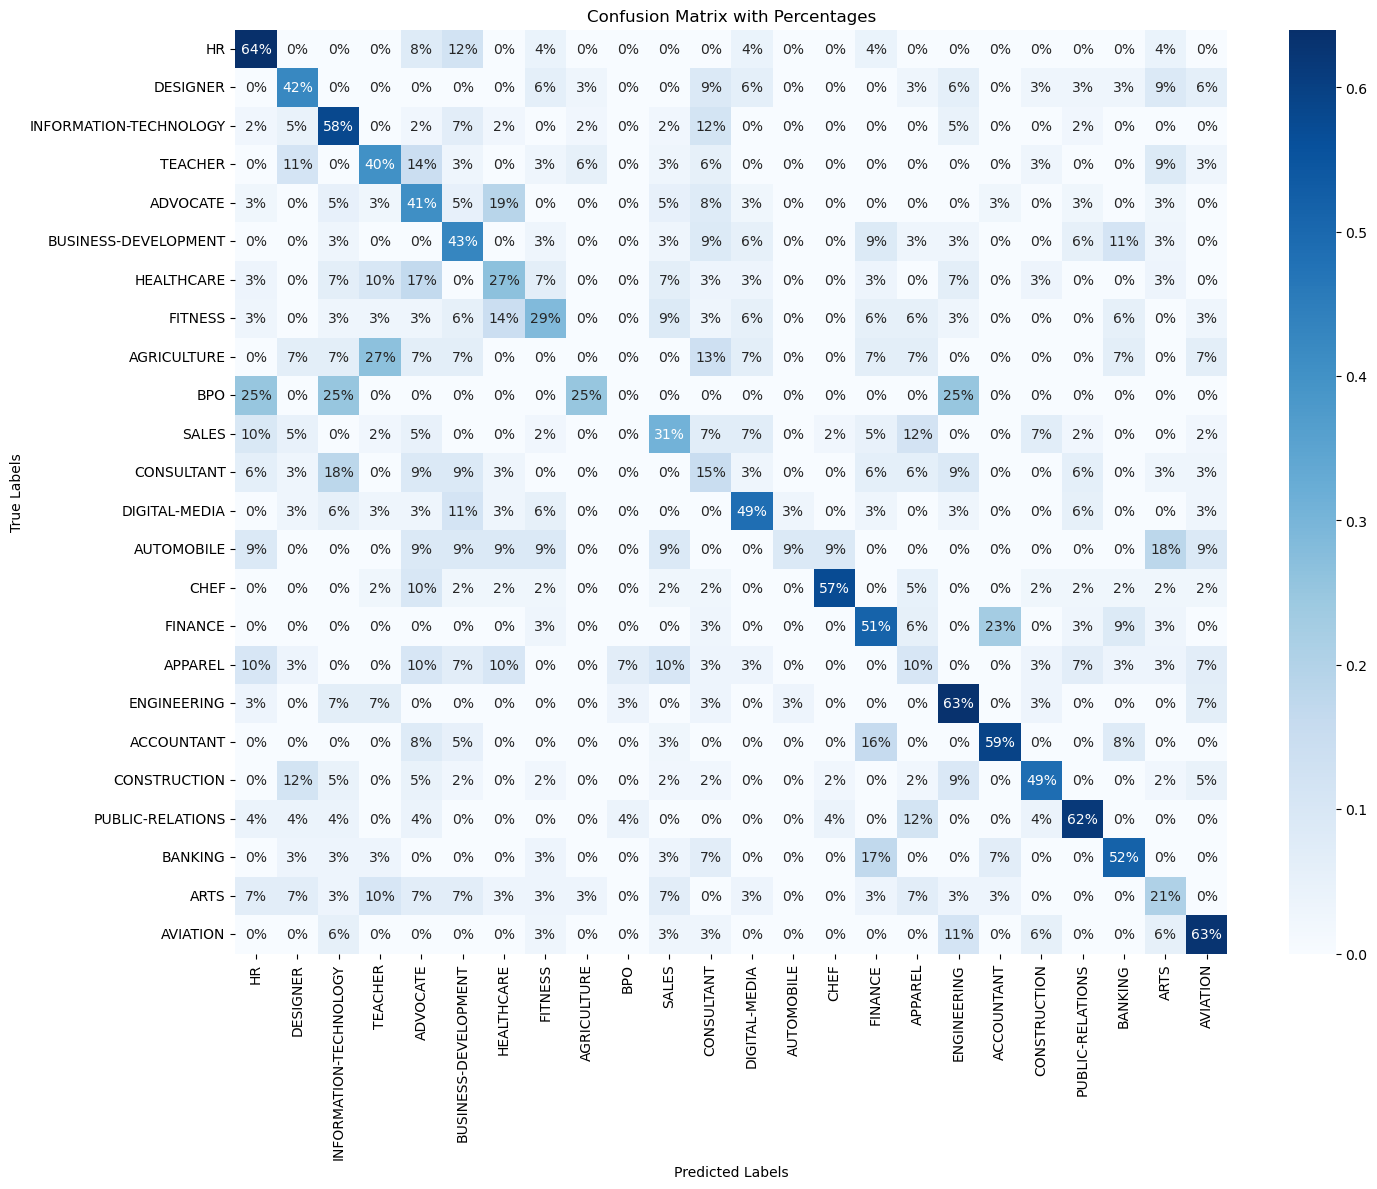

In [242]:
# Treinando e encontrando o melhor modelo XGBoost
xgb_model = XGBClassifier()
model_classification_xgb.building_best_model(xgb_model, xgb_param_dist, cv=5)

# Avaliando o modelo XGBoost
xgb_predictions = model_classification_xgb.predict(model_classification.df_validation)
xgb_metrics = model_classification_xgb.evaluation_metrics(model_classification.df_validation[target], xgb_predictions)
print(f'XGBoost Metrics: {xgb_metrics}')

# Plotando a matriz de confusão
model_classification_xgb.plot_confusion_matrix()

--------------------------


#### Cenário com dados do Artigo e Update

In [243]:
# Definindo as variáveis independentes (X) e a variável dependente (y)
variables = tfidf_df_curr.columns.tolist()  # As colunas TF-IDF como variáveis
df_tfidf_curr = tfidf_df_curr.copy()
print(variables)

target = 'Category' 

# Adicionando a coluna de rótulo ao DataFrame tfidf_df
df_tfidf_curr[target] = df_curr[target].replace({value:num for num,value in enumerate(df_curr[target].unique(),start=0)})
print(df_tfidf_curr[target])
# Inicializar a classe de classificação
model_classification = Model_Classification(df_tfidf_curr, variables, target, df_curr[target].unique())

['abc', 'abil', 'abus', 'academ', 'achiev', 'act', 'activ', 'ada', 'administr', 'admiss', 'adob', 'advanc', 'advertis', 'advisori', 'advoc', 'afghanistan', 'africa', 'age', 'aggreg', 'agil', 'air', 'airlin', 'ajax', 'al', 'allianc', 'alloc', 'allow', 'america', 'american', 'amravati', 'analys', 'analyt', 'analyz', 'anatomi', 'android', 'angel', 'angularj', 'annual', 'appli', 'applic', 'appoint', 'approach', 'appropri', 'approv', 'april', 'aptitud', 'arab', 'area', 'aris', 'arizona', 'arkansa', 'armi', 'arrang', 'art', 'articl', 'articul', 'asia', 'asian', 'asp', 'assembl', 'assign', 'assist', 'associ', 'assur', 'atlanta', 'attend', 'attitud', 'audit', 'aug', 'august', 'austin', 'autom', 'auxiliari', 'avail', 'averag', 'aviat', 'awar', 'award', 'bachelor', 'backup', 'balanc', 'bandra', 'bangalor', 'bank', 'base', 'baselin', 'basi', 'bay', 'beach', 'beauti', 'believ', 'benefit', 'bilingu', 'bill', 'billion', 'bin', 'bloomberg', 'bni', 'board', 'bombay', 'boston', 'box', 'branch', 'brand'

##### SVM

fold_f1: 0.06316919461215521
fold_f1: 0.05842953172700289
fold_f1: 0.06158107400794067
fold_f1: 0.057869765196986896
fold_f1: 0.06789524701311843
avg_f1:0.061788962511440816
fold_f1: 0.6610581284884733
fold_f1: 0.6678368310948047
fold_f1: 0.6344830730874097
fold_f1: 0.6296690680943056
fold_f1: 0.6627483437818502
avg_f1:0.6511590889093688
fold_f1: 0.6682207442852979
fold_f1: 0.6550421878732335
fold_f1: 0.6481283900310514
fold_f1: 0.6478232905193962
fold_f1: 0.6580673790322678
avg_f1:0.6554563983482493
fold_f1: 0.022618236115168628
fold_f1: 0.026984527044797056
fold_f1: 0.02271923023399137
fold_f1: 0.03004061412430551
fold_f1: 0.02257134737953152
avg_f1:0.024986790979558818
fold_f1: 0.6664489188026809
fold_f1: 0.6613054516398611
fold_f1: 0.6551582090695833
fold_f1: 0.6354326937946361
fold_f1: 0.6699375499840924
avg_f1:0.6576565646581708
Best params: {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}


/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM Metrics: {'accuracy': 0.5705996131528046, 'f1_score': 0.6687403362656624, 'recall': 0.6622745923857698, 'precision': 0.6985577823501663}
class_label: {0: 'HR', 1: 'DESIGNER', 2: 'INFORMATION-TECHNOLOGY', 3: 'TEACHER', 4: 'ADVOCATE', 5: 'BUSINESS-DEVELOPMENT', 6: 'HEALTHCARE', 7: 'FITNESS', 8: 'AGRICULTURE', 9: 'BPO', 10: 'SALES', 11: 'CONSULTANT', 12: 'DIGITAL-MEDIA', 13: 'AUTOMOBILE', 14: 'CHEF', 15: 'FINANCE', 16: 'APPAREL', 17: 'ENGINEERING', 18: 'ACCOUNTANT', 19: 'CONSTRUCTION', 20: 'PUBLIC-RELATIONS', 21: 'BANKING', 22: 'ARTS', 23: 'AVIATION', 24: 'DATA SCIENCE', 25: 'WEB DESIGNING', 26: 'MECHANICAL ENGINEER', 27: 'HEALTH AND FITNESS', 28: 'CIVIL ENGINEER', 29: 'JAVA DEVELOPER', 30: 'BUSINESS ANALYST', 31: 'SAP DEVELOPER', 32: 'AUTOMATION TESTING', 33: 'ELECTRICAL ENGINEERING', 34: 'OPERATIONS MANAGER', 35: 'PYTHON DEVELOPER', 36: 'DEVOPS ENGINEER', 37: 'NETWORK SECURITY ENGINEER', 38: 'PMO', 39: 'DATABASE', 40: 'HADOOP', 41: 'ETL DEVELOPER', 42: 'DOTNET DEVELOPER', 43: 'BLOCK

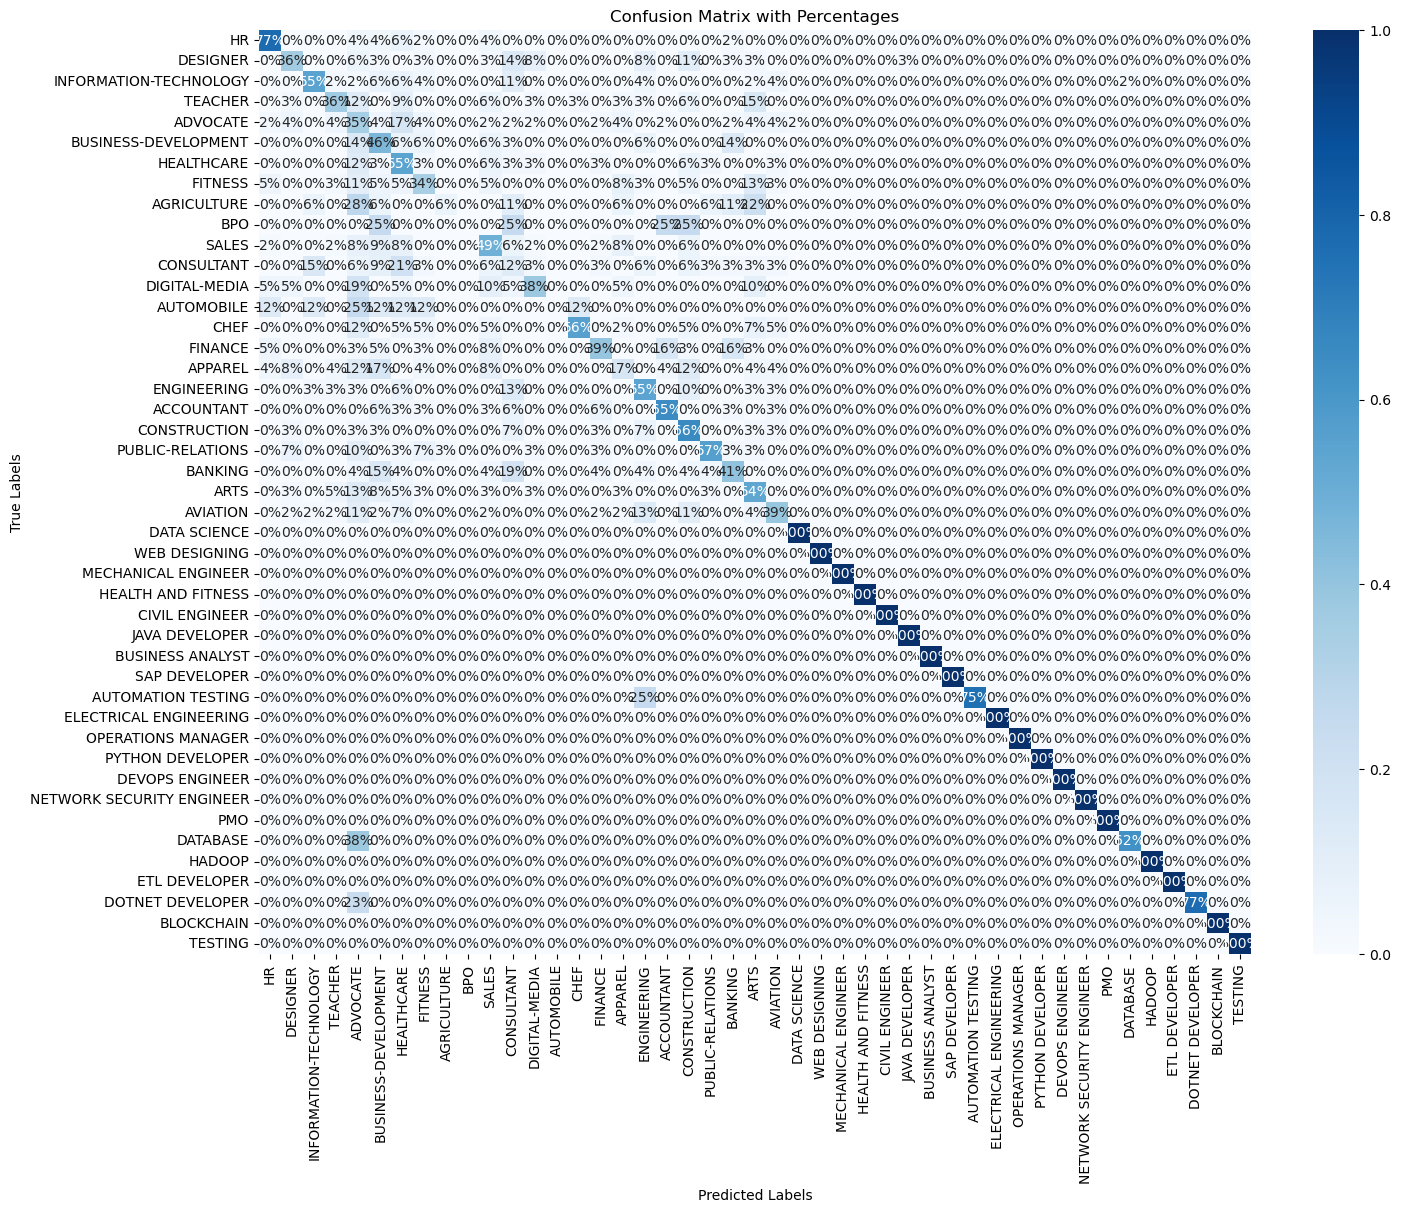

In [244]:

# Definindo os parâmetros para o SVM
svm_param_dist = [
    {'C': 0.1, 'kernel': 'linear'},
    {'C': 1, 'kernel': 'linear'},
    {'C': 10, 'kernel': 'linear'},
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale'},
    {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'},
    # {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'}
]

# Treinando e encontrando o melhor modelo SVM
svm_model = SVC()
model_classification.building_best_model(svm_model, svm_param_dist, cv=5)

# Avaliando o modelo SVM
svm_predictions = model_classification.predict(model_classification.df_validation)
svm_metrics = model_classification.evaluation_metrics(model_classification.df_validation[model_classification.target], svm_predictions)
print(f'SVM Metrics: {svm_metrics}')

# Plotando a matriz de confusão
model_classification.plot_confusion_matrix()

##### XGBoost

In [245]:
# Inicializar a classe de classificação
model_classification_xgb = Model_Classification(df_tfidf_curr, variables, target,df_curr[target].unique())

Target dentro da lista de variaveis: False


In [246]:


from itertools import product
# Definindo os parâmetros para o XGBoost
xgb_param_grid = {
    'n_estimators': [100],#, 200
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],#, 7
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Convertendo para lista de dicionários
keys, values = zip(*xgb_param_grid.items())
xgb_param_dist = [dict(zip(keys, v)) for v in product(*values)]


fold_f1: 0.6423894143946215
fold_f1: 0.5853085971688956
fold_f1: 0.5914469685183483
fold_f1: 0.593680491810701
fold_f1: 0.5919304786094749
avg_f1:0.6009511901004083
fold_f1: 0.6248498698842895
fold_f1: 0.5866204259562252
fold_f1: 0.5878088206481767
fold_f1: 0.577353924818163
fold_f1: 0.5879104839579761
avg_f1:0.5929087050529661
fold_f1: 0.6446179652384173
fold_f1: 0.6071833554115901
fold_f1: 0.6013263296214114
fold_f1: 0.5822009959197735
fold_f1: 0.5942424766210718
avg_f1:0.6059142245624528
fold_f1: 0.6273784747281373
fold_f1: 0.6045866564109164
fold_f1: 0.5820529841646268
fold_f1: 0.592357420032672
fold_f1: 0.5843275493885814
avg_f1:0.5981406169449868
fold_f1: 0.6517278663772352
fold_f1: 0.6025772916331947
fold_f1: 0.6027294628191225
fold_f1: 0.5939761117202279
fold_f1: 0.6086727194667548
avg_f1:0.6119366904033071
fold_f1: 0.6393366406558028
fold_f1: 0.5913551634247687
fold_f1: 0.5991295486257739
fold_f1: 0.6086493290278965
fold_f1: 0.5978948162092179
avg_f1:0.6072730995886919
fold_f1

/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBoost Metrics: {'accuracy': 0.5531914893617021, 'f1_score': 0.6467146106954639, 'recall': 0.6534408270796549, 'precision': 0.6510480836315929}
class_label: {0: 'HR', 1: 'DESIGNER', 2: 'INFORMATION-TECHNOLOGY', 3: 'TEACHER', 4: 'ADVOCATE', 5: 'BUSINESS-DEVELOPMENT', 6: 'HEALTHCARE', 7: 'FITNESS', 8: 'AGRICULTURE', 9: 'BPO', 10: 'SALES', 11: 'CONSULTANT', 12: 'DIGITAL-MEDIA', 13: 'AUTOMOBILE', 14: 'CHEF', 15: 'FINANCE', 16: 'APPAREL', 17: 'ENGINEERING', 18: 'ACCOUNTANT', 19: 'CONSTRUCTION', 20: 'PUBLIC-RELATIONS', 21: 'BANKING', 22: 'ARTS', 23: 'AVIATION', 24: 'DATA SCIENCE', 25: 'WEB DESIGNING', 26: 'MECHANICAL ENGINEER', 27: 'HEALTH AND FITNESS', 28: 'CIVIL ENGINEER', 29: 'JAVA DEVELOPER', 30: 'BUSINESS ANALYST', 31: 'SAP DEVELOPER', 32: 'AUTOMATION TESTING', 33: 'ELECTRICAL ENGINEERING', 34: 'OPERATIONS MANAGER', 35: 'PYTHON DEVELOPER', 36: 'DEVOPS ENGINEER', 37: 'NETWORK SECURITY ENGINEER', 38: 'PMO', 39: 'DATABASE', 40: 'HADOOP', 41: 'ETL DEVELOPER', 42: 'DOTNET DEVELOPER', 43: 'B

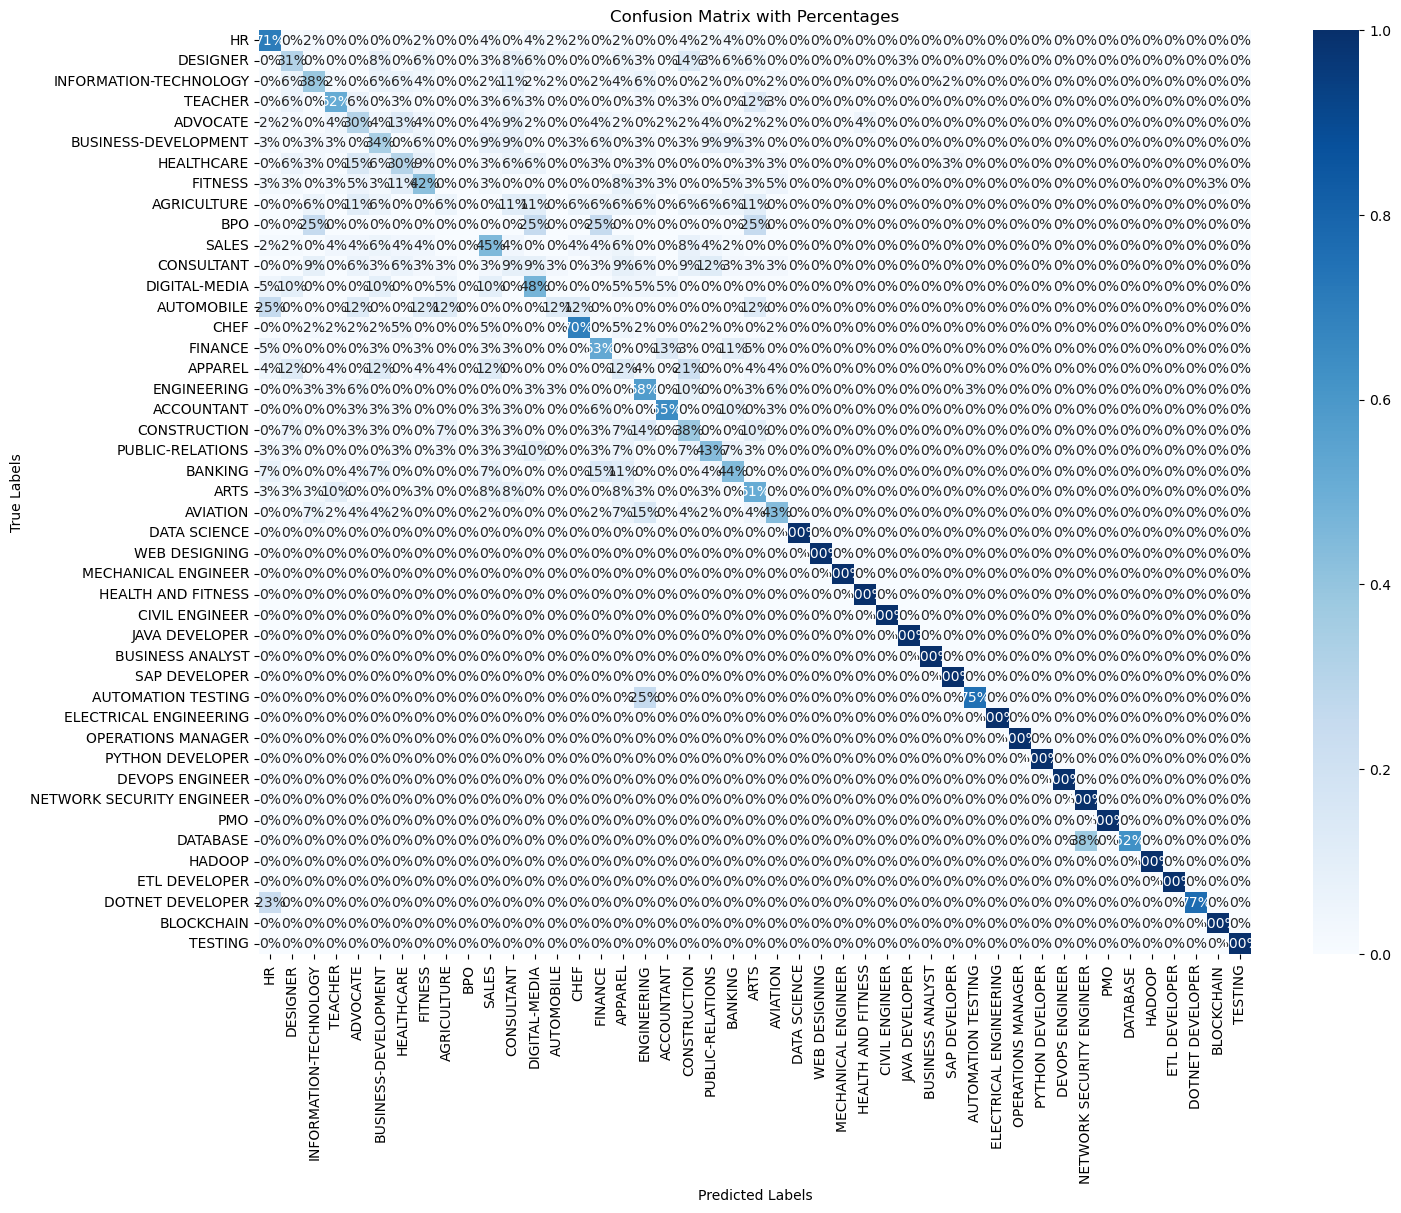

In [247]:
# Treinando e encontrando o melhor modelo XGBoost
xgb_model = XGBClassifier()
model_classification_xgb.building_best_model(xgb_model, xgb_param_dist, cv=5)

# Avaliando o modelo XGBoost
xgb_predictions = model_classification_xgb.predict(model_classification.df_validation)
xgb_metrics = model_classification_xgb.evaluation_metrics(model_classification.df_validation[target], xgb_predictions)
print(f'XGBoost Metrics: {xgb_metrics}')

# Plotando a matriz de confusão
model_classification_xgb.plot_confusion_matrix()